In [85]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")

In [86]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [88]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.582213784705215
Explained variance ratio for 10 components: 0.7008253277875917
Explained variance ratio for 15 components: 0.7601916518158807
EOFs shape for 5 components: (eof, lat, lon) (5, 13, 35)
EOFs shape for 10 components: (eof, lat, lon) (10, 13, 35)
EOFs shape for 15 components: (eof, lat, lon) (15, 13, 35)
PCs shape for 5 components: (eof, time) (5, 864)
PCs data for 5 components: <xarray.DataArray (eof: 5, time: 864)>
array([[ -6.29767607,  -6.92623833,  -6.06612333, ...,  -8.78229121,
        -10.73037298, -11.51841333],
       [ -1.32017404,  -0.94989193,  -0.17729692, ...,   3.58378544,
          3.30997491,   0.36169654],
       [ -2.06665407,  -2.59613481,  -2.82771537, ...,  -3.4182697 ,
         -4.84755448,  -4.01489664],
       [  0.20367141,   0.53551723,  -0.3787257 , ...,  -1.01851438,
         -0.44632774,  -1.55272391],
       [ -0.18501951,   1.66550565,   1.91981515, ...,  -0.80691903,
          0.88234102,   1.1375

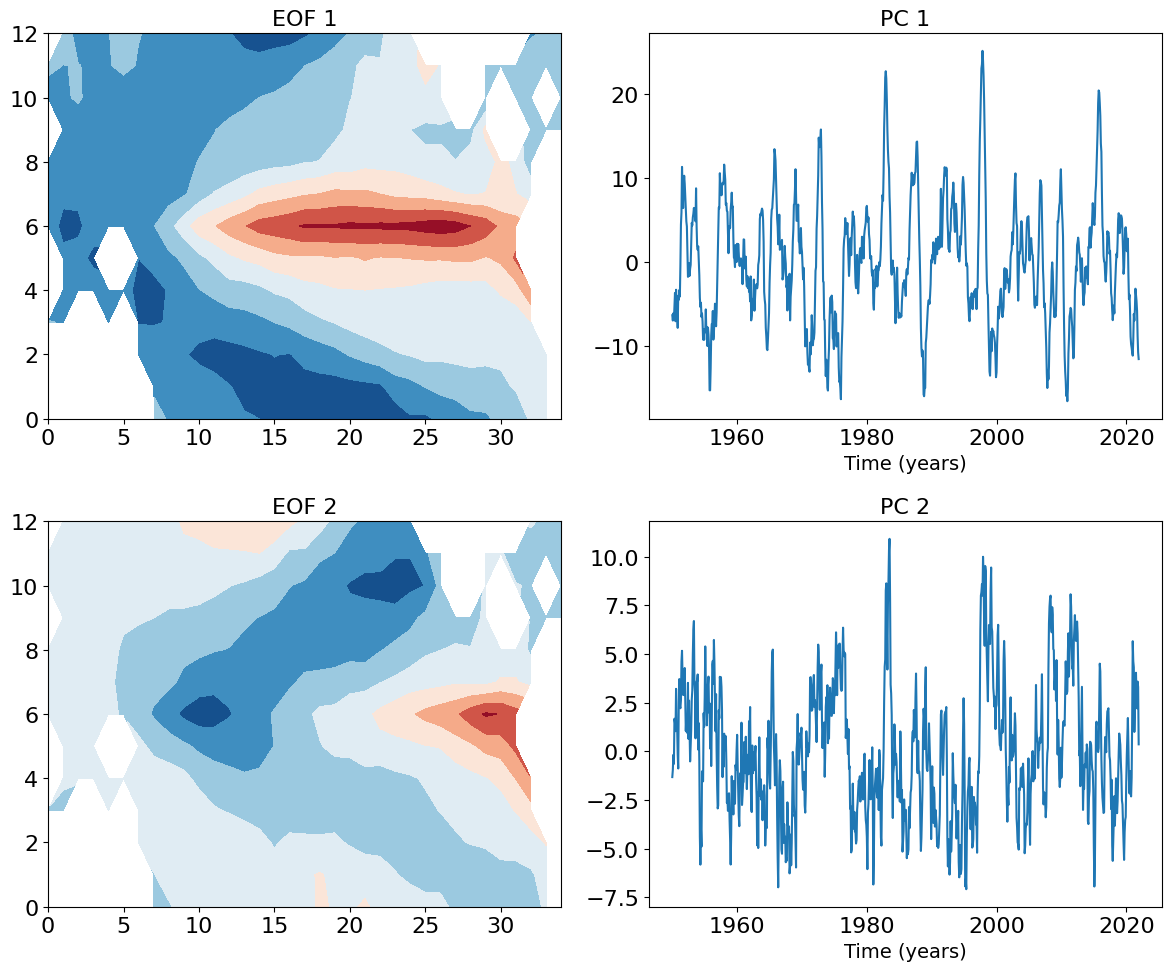

In [89]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [90]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [91]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)


Eigenvalues - real: [0.89887694 0.87550746 0.87550746 0.854219   0.854219   0.80582016
 0.74994652 0.69133989 0.69133989 0.66060494]
Frobenius norm: 0.728785696127562


In [92]:
#Create forecast with LIM using forecast lag

lag = 2

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data
# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

print("Forecasting mean using LIM model : {}".format(x_frcst))

G_tau: [[ 8.98461023e-01+1.34566284e-17j -1.23921563e-02+3.13751040e-18j
   1.60068599e-01-4.90972317e-17j -2.12294067e-01+5.38412264e-17j
   4.91798529e-01+8.84623948e-17j -3.53695344e-01-2.34653111e-17j
  -3.90523468e-02-1.85940458e-17j  2.91354483e-01-1.63989273e-17j
   7.53966622e-02+2.67278423e-17j  1.33306161e-01-1.63624854e-17j]
 [-6.00629041e-03-2.05534953e-17j  7.83185562e-01-1.11429560e-17j
   3.02695280e-02-2.02043386e-17j -5.69853015e-02+5.90737157e-18j
   1.19325359e-01-5.96400866e-17j -5.45254728e-02+3.07520623e-17j
  -5.01572324e-02+2.61836224e-17j -4.35905039e-03-3.72220960e-17j
  -5.52781136e-02+2.37313551e-18j  5.29533492e-02-2.19197347e-17j]
 [-1.90535388e-02+7.62727783e-18j  3.82383630e-02+2.05279089e-18j
   7.80948678e-01-4.60055830e-17j -4.29611065e-02+7.50091047e-17j
  -1.12768664e-01+1.14273582e-16j -2.59793563e-02+4.59340223e-17j
   1.36199065e-02-6.37413090e-17j  1.71136613e-02+6.08654679e-17j
  -1.80510228e-01+5.97859718e-17j  1.58598456e-02+2.89959009e-17j]


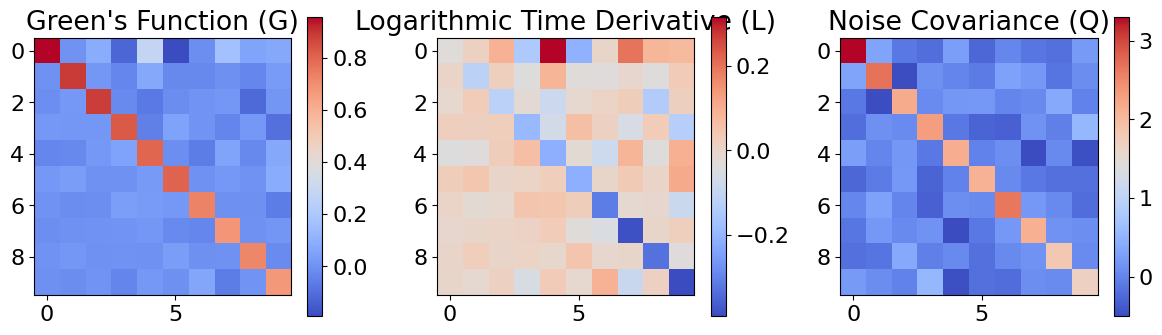

In [93]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

G_tau: [[ 8.98461023e-01+1.34566284e-17j -1.23921563e-02+3.13751040e-18j
   1.60068599e-01-4.90972317e-17j -2.12294067e-01+5.38412264e-17j
   4.91798529e-01+8.84623948e-17j -3.53695344e-01-2.34653111e-17j
  -3.90523468e-02-1.85940458e-17j  2.91354483e-01-1.63989273e-17j
   7.53966622e-02+2.67278423e-17j  1.33306161e-01-1.63624854e-17j]
 [-6.00629041e-03-2.05534953e-17j  7.83185562e-01-1.11429560e-17j
   3.02695280e-02-2.02043386e-17j -5.69853015e-02+5.90737157e-18j
   1.19325359e-01-5.96400866e-17j -5.45254728e-02+3.07520623e-17j
  -5.01572324e-02+2.61836224e-17j -4.35905039e-03-3.72220960e-17j
  -5.52781136e-02+2.37313551e-18j  5.29533492e-02-2.19197347e-17j]
 [-1.90535388e-02+7.62727783e-18j  3.82383630e-02+2.05279089e-18j
   7.80948678e-01-4.60055830e-17j -4.29611065e-02+7.50091047e-17j
  -1.12768664e-01+1.14273582e-16j -2.59793563e-02+4.59340223e-17j
   1.36199065e-02-6.37413090e-17j  1.71136613e-02+6.08654679e-17j
  -1.80510228e-01+5.97859718e-17j  1.58598456e-02+2.89959009e-17j]


Text(0.5, 0, 'Time')

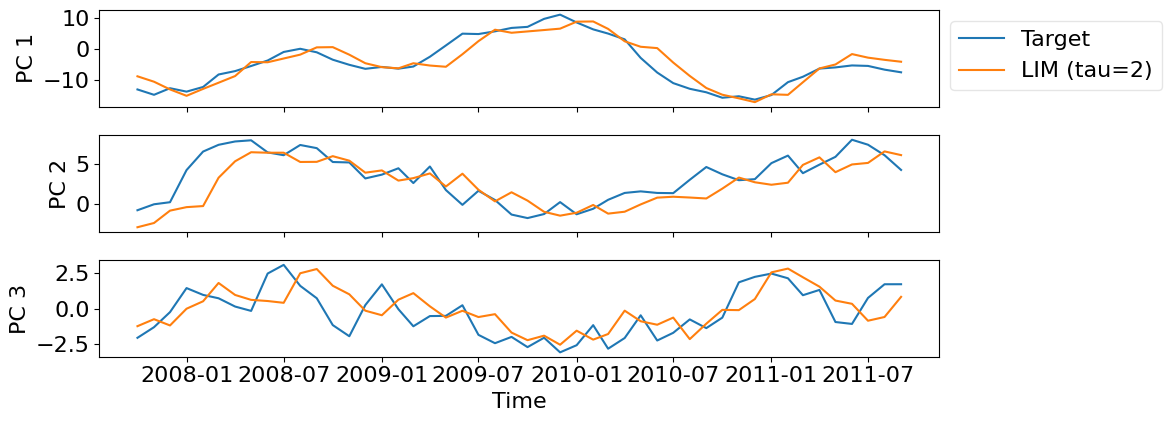

In [94]:
# Forecasting

# Define lag
lag = 2

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

Reconstructed input data shape: (48, 13, 35)
Reconstructed forecast data shape: (48, 13, 35)


Text(0.5, 1.0, 'Forecast')

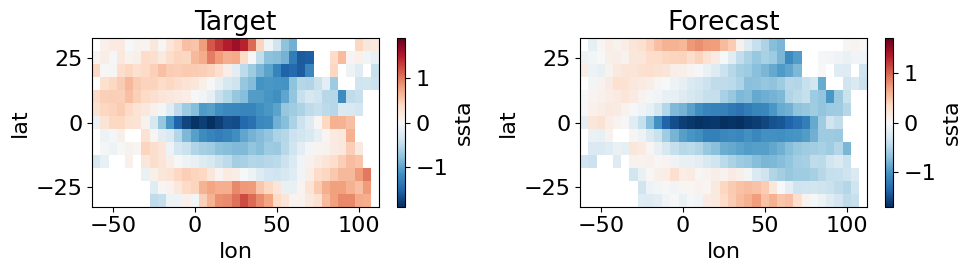

In [95]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")